In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

import gym
from gym_utils_q_learning import AtariEnv
from gym_utils_q_learning import AtariFrame
from AtariACModels import AtariActorModel, AtariCriticModel
import numpy as np
import random

#environment_name = "SpaceInvaders-v4"
environment_name  = "SpaceInvadersNoFrameskip-v4"

# environment_name = "Pong-v4"
# typical_bad_game_frame_count = 1100
# reward_frame_shift = -1

action_count = gym.make(environment_name).action_space.n

In [2]:
#play a quick game to test out gym_utils

if False:
    atari_env = AtariEnv(environment_name)
    model = AtariActorModel(action_count).cuda()
    action = atari_env.env.action_space.sample()

    for i in range(4000):
        atari_frame = atari_env.step(action)
        if atari_frame is None:
            break
        processed_frames = atari_frame.get_next_processed_frames()
        #print("processed_frames.shape: {}".format(processed_frames.shape))
        processed_frames = np.reshape(processed_frames, (1,)+processed_frames.shape)
        #print("processed_frames.shape: {}".format(processed_frames.shape))
        img_tensor = torch.from_numpy(processed_frames).float().cuda()

        output = model(img_tensor)
        action_array = output.detach().cpu().numpy()[0]
        print("model_actions: {}".format(action_array))
        action = np.argmax(action_array)

    atari_env.close()
    
    print("len(atari_env.frame_buffer): {}".format(len(atari_env.frame_buffer)))
    atariFrame = atari_env.frame_buffer[107]
    processed_frames = atariFrame.get_processed_frames()
    print("processed_frames.shape: {}".format(processed_frames.shape))
    print("sample_frame.frame_index: {}".format(atariFrame.frame_index))
    print("sample_frame.reward_list: {}".format(atariFrame.reward_list))
    atariFrame.show_processed_frame()

In [3]:
#play a game. feed each frame into the model and see what we get
def play_game(atari_env, model, epsilon, max_frames=5000, debug=False):
    current_action = 0
    done = False
    frame_counter = 0
    action_count = atari_env.env.action_space.n
    choices = np.arange(action_count)
    
    while not done:
        save_step = frame_counter >= 60
        atari_frame = atari_env.step(current_action, save_step=save_step)

        if atari_frame is None:  #processed_frames == None
            done = True
            continue
            
        processed_frames = atari_frame.get_processed_frames()

        processed_frames_batch = np.reshape(processed_frames, (1,)+processed_frames.shape)
        img_tensor = torch.from_numpy(processed_frames_batch).float().cuda()
        output = model(img_tensor)
        action_array = output.detach().cpu().numpy()[0]
        if debug:
            print("actions from model: {}".format(action_array))
            
            #action_for_critic_reshaped = np.reshape(action_array, (1, 1))
            action_for_critic_reshaped = np.zeros((1,1))
            action_for_critic_reshaped[0][0] = current_action
            action_for_critic_reshaped = action_batch_to_one_hot(action_count, action_for_critic_reshaped)
            action_for_critic_tensor = torch.from_numpy(action_for_critic_reshaped).float().cuda()
            
            critic_model_target.eval()
            critic_val = critic_model_target(img_tensor, action_for_critic_tensor)
            critic_model_target.train()
            print("critic val for action: {} = {}".format(action_for_critic_tensor, critic_val))
    
        rand = random.uniform(0, 1)
        if rand < epsilon:
            current_action = atari_env.env.action_space.sample()
        else:
            #current_action = np.argmax(action_array)
            current_action = np.random.choice(choices, p=action_array)

        frame_counter += 1
        if frame_counter > max_frames:
            break

def game_step(atari_env, model, epsilon, max_frames=5000):
    current_action = 0
    done = False
    
    frame = atari_env.frame_buffer[-1]
    processed_frames = frame.get_next_processed_frames()

    processed_frames_batch = np.reshape(processed_frames, (1,)+processed_frames.shape)
    img_tensor = torch.from_numpy(processed_frames_batch).float().cuda()
    output = model(img_tensor)
    action_array = output.detach().cpu().numpy()[0]

    rand = random.uniform(0, 1)
    if rand < epsilon:
        current_action = atari_env.env.action_space.sample()
    else:
        current_action = np.argmax(action_array)

    atari_frame = atari_env.step(current_action, save_step=save_step)

    if atari_frame is None:
        return True
    
    return False

            
def get_train_batch(atari_env, batch_size, lambda_frames, gamma):
    rand_arr = np.arange(len(atari_env.frame_buffer)-1-lambda_frames)
    np.random.shuffle(rand_arr)
   
    index_counter = 0
    batch_index_counter = 0
    
    frame_batch        = np.zeros((batch_size, 4, 210, 160))
    next_frame_batch   = np.zeros((batch_size, 4, 210, 160))
    reward_batch       = np.zeros(batch_size)
    actions_batch      = np.zeros(batch_size)
    next_actions_batch = np.zeros(batch_size)
    frame_number_batch = np.zeros(batch_size)
    lambda_reward      = np.zeros(batch_size)
    
    for batch_index in range(batch_size):
        frame_number = rand_arr[batch_index]
        
        for i in range(lambda_frames):
            lambda_reward[batch_index] += gamma**(i+1) * atari_env.frame_buffer[frame_number+i].getReward()
        
        atari_frame = atari_env.frame_buffer[frame_number]
        next_atari_frame = atari_env.frame_buffer[frame_number+1]
        lambda_end_atari_frame = atari_env.frame_buffer[frame_number+lambda_frames]
        
        frame_batch[batch_index]      = atari_frame.get_processed_frames()
        next_frame_batch[batch_index] = lambda_end_atari_frame.get_next_processed_frames()
        reward_batch[batch_index]     = atari_frame.getReward()
        actions_batch[batch_index]    = atari_frame.action_taken
        #next_actions_batch[batch_index] = next_atari_frame.action_taken
        next_actions_batch[batch_index] = lambda_end_atari_frame.action_taken
        frame_number_batch[batch_index] = frame_number

    return frame_batch, next_frame_batch, actions_batch, next_actions_batch, reward_batch, frame_number_batch, lambda_reward
    
def action_batch_to_one_hot(action_count, action_batch):
#     print(action_batch.shape)
#     print(action_batch)
    return_value = np.zeros((action_batch.shape[0], action_count))
    for i in range(action_batch.shape[0]):
        this_row = np.zeros(action_count)
#         print("action_batch[i][0]: {}".format(action_batch[i][0]))
        this_row[int(action_batch[i][0])] = 1.0
        return_value[i] = this_row
    return return_value
    
    

def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        

In [4]:
actor_model_local  = AtariActorModel(action_count).cuda()
actor_model_target = AtariActorModel(action_count).cuda()

critic_model_local  = AtariCriticModel(action_count).cuda()
critic_model_target = AtariCriticModel(action_count).cuda()

atari_env_train = AtariEnv(environment_name)


In [ ]:
learning_rate_actor = .0005 #.000005
learning_rate_critic = .005 #.000005
actor_optimizer = optim.Adam(actor_model_local.parameters(), lr=learning_rate_actor)
critic_optimizer = optim.Adam(critic_model_local.parameters(), lr=learning_rate_critic)

epochs = 50 #100
gamma = .98
lambda_frames = 10
TAU = .001 #1e-3  

epsilon_max = 0.30
epsilon_min = 0.10
epsilon_decay_frames = 50000
trainings_per_epoch = 100
batch_size = 128

for epoch in range(epochs):
    total_critic_loss = 0
    total_actor_loss = 0
    
    #play a game. game info is saved to the AtariEnv object
    atari_env_train.reset()     
    epsilon = epsilon_max - (epsilon_max-epsilon_min)*(atari_env_train.global_step_counter/epsilon_decay_frames)
    epsilon = max(epsilon_min, epsilon)
    actor_model_local.eval()
    play_game(atari_env_train, actor_model_local, epsilon)  
    actor_model_local.train()
    
    for training_iter in range(trainings_per_epoch):
        
        # TODO - instead of palying a whole game, move forward one step and train a batch.
        
        if atari_env_train.global_step_counter < 8000:
            continue
        
        frame_batch, next_frame_batch, actions_batch, next_actions_batch, reward_batch, frame_number_batch, lambda_reward_batch = get_train_batch(atari_env_train, batch_size, lambda_frames, gamma)

        # print(frame_batch.shape)
        # print(next_frame_batch.shape)
        # print(actions_batch)
        # print(reward_batch)
        # print(frame_number_batch)

        # convert to tensors for input into the models.
        reward_batch_reshaped = np.reshape(reward_batch, (batch_size, 1))   #unsqueeze?
        reward_batch_tensor = torch.from_numpy(reward_batch_reshaped).float().cuda()
        
        img_tensor = torch.from_numpy(frame_batch).float().cuda()
        img_tensor_next = torch.from_numpy(next_frame_batch).float().cuda()
        
        actions_batch_reshaped = np.reshape(actions_batch, (batch_size, 1))
        actions_batch_reshaped = action_batch_to_one_hot(action_count, actions_batch_reshaped)
        actions_batch_tensor = torch.from_numpy(actions_batch_reshaped).float().cuda()
        #print("actions_batch_tensor: {}".format(actions_batch_tensor))
        
        next_actions_batch_reshaped = np.reshape(next_actions_batch, (batch_size, 1))
        next_actions_batch_reshaped = action_batch_to_one_hot(action_count, next_actions_batch_reshaped)
        next_actions_batch_tensor = torch.from_numpy(next_actions_batch_reshaped).float().cuda()
        #print("next_actions_batch_tensor: {}".format(next_actions_batch_tensor))
        
        lambda_reward_batch_reshaped = np.reshape(lambda_reward_batch, (batch_size, 1))
        lambda_reward_batch_tensor = torch.from_numpy(lambda_reward_batch_reshaped).float().cuda()
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models

        # Compute Q targets for current states (y_i)
        ##### TODO - instead of using historical next actions, use the target actor model for next actions
        Q_targets_next = critic_model_target(img_tensor_next, next_actions_batch_tensor) #note "next" values are end of lambda frames
        
        #Q_targets = reward_batch_tensor + (gamma * Q_targets_next)
        Q_targets = lambda_reward_batch_tensor + (gamma**lambda_frames * Q_targets_next)
            
        # Compute critic loss
        Q_expected = critic_model_local(img_tensor, actions_batch_tensor)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
            
        # Minimize the critic loss
        critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(critic_model_local.parameters(), 1)
        critic_optimizer.step()
        total_critic_loss += critic_loss.item()
            
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = actor_model_local(img_tensor)
        actor_loss = -critic_model_local(img_tensor, actions_pred).mean()
            
        # Minimize the actor loss
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        total_actor_loss += actor_loss.item()
            
        # ----------------------- update target networks ----------------------- #
        #use very small Tau and update with every step
        soft_update(critic_model_local, critic_model_target, TAU)
        soft_update(actor_model_local, actor_model_target, TAU)

    print("epoch: {}, score: {}, epsilon: {:.3f}, frames ran: {}, critic loss: {:.6f}, actor_loss: {:.6f}".format(epoch, atari_env_train.current_score, epsilon, atari_env_train.global_step_counter, total_critic_loss/trainings_per_epoch, total_actor_loss/trainings_per_epoch))
    
atari_env_train.close()

epoch: 0, score: 20.0, epsilon: 0.245, frames ran: 16688, critic loss: 0.192707, actor_loss: -0.010900
epoch: 1, score: 20.0, epsilon: 0.233, frames ran: 19328, critic loss: 0.152480, actor_loss: -0.026083
epoch: 2, score: 5.0, epsilon: 0.223, frames ran: 20632, critic loss: 0.142523, actor_loss: -0.027082
epoch: 3, score: 14.0, epsilon: 0.217, frames ran: 24076, critic loss: 0.152105, actor_loss: -0.027384
epoch: 4, score: 18.0, epsilon: 0.204, frames ran: 27132, critic loss: 0.169581, actor_loss: -0.041630
epoch: 5, score: 17.0, epsilon: 0.191, frames ran: 30928, critic loss: 0.163320, actor_loss: -0.040935
epoch: 6, score: 9.0, epsilon: 0.176, frames ran: 32972, critic loss: 0.147697, actor_loss: -0.044433
epoch: 7, score: 8.0, epsilon: 0.168, frames ran: 34756, critic loss: 0.142716, actor_loss: -0.053282
epoch: 8, score: 17.0, epsilon: 0.161, frames ran: 37636, critic loss: 0.159908, actor_loss: -0.056026
epoch: 9, score: 14.0, epsilon: 0.149, frames ran: 39620, critic loss: 0.130

In [10]:
torch.save(actor_model_local.state_dict(), "space_invaders_actor_local.pt")
torch.save(actor_model_target.state_dict(), "space_invaders_actor_target.pt")
torch.save(critic_model_local.state_dict(), "space_invaders_critic_local.pt")
torch.save(critic_model_target.state_dict(), "space_invaders_critic_target.pt")




In [9]:
# actor_model_local.load_state_dict(torch.load("space_invaders_actor_local.pt"))
# actor_model_target.load_state_dict(torch.load("space_invaders_actor_target.pt"))

#critic_model_local.load_state_dict(torch.load("space_invaders_critic_local.pt"))
#critic_model_target.load_state_dict(torch.load("space_invaders_critic_target.pt"))

# actor_model_target.load_state_dict(torch.load("space_invaders_actor_local.pt"))
# critic_model_target.load_state_dict(torch.load("space_invaders_critic_local.pt"))


#play a game using the model
atari_env_play = AtariEnv(environment_name)
atari_env_play.reset()

actor_model_local.eval()
play_game(atari_env_play, actor_model_local, 0.05, max_frames=4000, debug=True)
print("score: {}".format(atari_env_play.current_score))
actor_model_local.train()

atari_env_play.reset()
actor_model_target.eval()
play_game(atari_env_play, actor_model_local, 0.05)
print("score: {}".format(atari_env_play.current_score))
actor_model_target.train()

#print("score: {}".format(atari_env_play.current_score))
atari_env_play.close()

actions from model: [0.08950356 0.36442062 0.06442233 0.07073161 0.24648035 0.16444153]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[-0.1218]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.08657901 0.36162552 0.0638478  0.07077324 0.25218898 0.16498542]
critic val for action: tensor([[0., 1., 0., 0., 0., 0.]], device='cuda:0') = tensor([[-0.0846]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.09715132 0.36687502 0.06691989 0.06971918 0.236568   0.16276653]
critic val for action: tensor([[0., 0., 1., 0., 0., 0.]], device='cuda:0') = tensor([[-0.1283]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.10066807 0.36644134 0.06779599 0.06952051 0.23329133 0.16228276]
critic val for action: tensor([[0., 1., 0., 0., 0., 0.]], device='cuda:0') = tensor([[-0.1580]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.08950356 0.36442062 0.06442233 0.07073161 0.24648035 0.16444153]
crit

actions from model: [0.01093805 0.02145774 0.00303515 0.01178487 0.24856602 0.70421815]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.0801]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.0108323  0.02149335 0.00307345 0.01179816 0.24550477 0.7072979 ]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.0558]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.0112909  0.02229528 0.00305987 0.01207526 0.24265353 0.70862514]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[-0.0147]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.01228976 0.02330143 0.00319202 0.01278199 0.24944595 0.6989888 ]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.0731]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.01162314 0.02294172 0.00323482 0.01254602 0.2539655  0.69568884]
crit

actions from model: [0.19299501 0.04967898 0.20841122 0.11987261 0.01531055 0.4137316 ]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[0.0734]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.18792005 0.04951648 0.21172442 0.11829825 0.01552459 0.4170162 ]
critic val for action: tensor([[0., 1., 0., 0., 0., 0.]], device='cuda:0') = tensor([[0.0174]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.18538328 0.04912627 0.20592204 0.11766734 0.01500112 0.42689994]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.0289]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.19405237 0.05040904 0.21394636 0.12310244 0.01518418 0.4033056 ]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.0340]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.19668263 0.05084065 0.21680643 0.12585653 0.01517669 0.39463717]
critic

actions from model: [0.12281481 0.17908615 0.4001434  0.0827123  0.14922087 0.06602254]
critic val for action: tensor([[0., 0., 1., 0., 0., 0.]], device='cuda:0') = tensor([[-0.0941]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.12187497 0.17918897 0.40093604 0.08155558 0.15073574 0.06570873]
critic val for action: tensor([[0., 0., 1., 0., 0., 0.]], device='cuda:0') = tensor([[-0.1079]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.12180967 0.17867383 0.40132803 0.08326127 0.15051423 0.06441301]
critic val for action: tensor([[0., 0., 1., 0., 0., 0.]], device='cuda:0') = tensor([[-0.1226]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.11925288 0.17980774 0.4020168  0.08420345 0.15048671 0.06423242]
critic val for action: tensor([[0., 0., 1., 0., 0., 0.]], device='cuda:0') = tensor([[-0.1167]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.11868639 0.18262969 0.40286618 0.08228952 0.14744131 0.06608687]
crit

actions from model: [0.18609688 0.14582196 0.01680358 0.04210769 0.40945533 0.1997145 ]
critic val for action: tensor([[0., 0., 1., 0., 0., 0.]], device='cuda:0') = tensor([[-0.2134]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.1836297  0.15069701 0.01724798 0.04254967 0.40145883 0.20441681]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.2132]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.18243223 0.14941746 0.01722717 0.04311867 0.40770403 0.2001004 ]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[-0.2161]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.17903076 0.14505345 0.0165218  0.0417557  0.41734052 0.2002978 ]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[-0.2210]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.1798253  0.14757258 0.01522474 0.03995958 0.424838   0.19257984]
crit

actions from model: [0.19699642 0.0532318  0.20077287 0.12616388 0.01883896 0.40399605]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[-0.1789]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.19963302 0.05338184 0.20333792 0.12585752 0.01881174 0.39897797]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.1748]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.19084294 0.05241115 0.20212671 0.12271096 0.01946977 0.41243842]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.1711]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.18684372 0.05301613 0.20585379 0.1225635  0.01977503 0.4119478 ]
critic val for action: tensor([[0., 0., 1., 0., 0., 0.]], device='cuda:0') = tensor([[-0.1264]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.19017662 0.05258811 0.20146288 0.12254175 0.01968616 0.41354442]
crit

actions from model: [0.05884428 0.05769351 0.04604593 0.7907296  0.04102409 0.00566262]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.1147]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.09395514 0.10255993 0.06950326 0.6757463  0.04792868 0.01030662]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.2013]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.0935988  0.10377557 0.06804738 0.6773087  0.04703827 0.01023125]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.2048]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.0915356  0.10028476 0.06974158 0.6807452  0.04753155 0.01016138]
critic val for action: tensor([[0., 1., 0., 0., 0., 0.]], device='cuda:0') = tensor([[-0.1604]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.09166518 0.10208445 0.07187774 0.67587703 0.0480007  0.01049488]
crit

actions from model: [0.07847574 0.05129176 0.09752943 0.7265051  0.03765229 0.00854573]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.1401]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.08641527 0.05212734 0.10205846 0.7142793  0.0364539  0.00866582]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.1828]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.08843181 0.05146117 0.10304561 0.7124067  0.03600302 0.00865172]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[-0.2437]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.08031736 0.05117926 0.09843703 0.72470707 0.03683124 0.00852801]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.1691]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.07847574 0.05129176 0.09752943 0.7265051  0.03765229 0.00854573]
crit

actions from model: [0.13821779 0.04989596 0.10989734 0.29753876 0.3501434  0.05430678]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[-0.0998]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14517725 0.05346665 0.10880622 0.30341923 0.33159956 0.05753111]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.1385]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14062776 0.05380387 0.10874678 0.30967236 0.32613644 0.0610128 ]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.1434]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.1340184  0.05124082 0.10446242 0.30172798 0.3468051  0.06174528]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.1515]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.13272585 0.05005399 0.10510128 0.30548775 0.3495001  0.05713107]
crit

actions from model: [0.14614408 0.15631466 0.06951389 0.11381229 0.20147893 0.31273618]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[-0.1056]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14609677 0.15487556 0.06978552 0.1135239  0.2019255  0.31379277]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[-0.1085]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14408681 0.15978321 0.07034145 0.11292174 0.19865069 0.31421608]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[-0.1039]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14475892 0.15691999 0.06888413 0.11352467 0.200719   0.31519333]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[-0.1137]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14592367 0.15486158 0.06736813 0.11308564 0.20293401 0.31582695]
crit

actions from model: [0.22337455 0.11902559 0.09266334 0.3720664  0.13888164 0.05398845]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[-0.1268]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.22684965 0.11585473 0.09013931 0.36909285 0.1454756  0.05258792]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[-0.1032]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.22530678 0.11978723 0.09292216 0.37016365 0.13773169 0.05408851]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.1235]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.22118941 0.11730697 0.09291012 0.3765929  0.13793032 0.05407031]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.1268]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.22014694 0.12389117 0.09317502 0.37174392 0.13670716 0.05433588]
crit

actions from model: [0.14906317 0.10111985 0.12397141 0.39178222 0.16337301 0.07069039]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[0.0365]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14899151 0.10061353 0.12294505 0.39243963 0.1635556  0.07145471]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.0050]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14816555 0.10031474 0.12201118 0.39277464 0.1651988  0.07153501]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[0.0152]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14773889 0.10117953 0.12096945 0.39378765 0.16452354 0.07180098]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[0.0091]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14866951 0.10158335 0.12226197 0.39208367 0.16397582 0.07142566]
critic v

actions from model: [0.28655866 0.1313418  0.06403967 0.3467829  0.09346622 0.07781073]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[0.1762]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.27929822 0.1294694  0.06413897 0.3523125  0.09778269 0.07699819]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.1452]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.281928   0.1288597  0.06394426 0.35288945 0.09706379 0.07531476]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[0.1190]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14552605 0.09938192 0.11651336 0.36111674 0.1553043  0.1221576 ]
critic val for action: tensor([[0., 1., 0., 0., 0., 0.]], device='cuda:0') = tensor([[0.0797]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.14663771 0.09848879 0.11876079 0.356039   0.15358105 0.12649275]
critic v

actions from model: [0.17548352 0.08212424 0.07266268 0.14504686 0.319516   0.20516664]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.0962]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.17695805 0.08032555 0.07379532 0.14276034 0.3274195  0.19874129]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.0989]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.17724803 0.07926665 0.07412313 0.14031723 0.32381487 0.20523003]
critic val for action: tensor([[0., 0., 1., 0., 0., 0.]], device='cuda:0') = tensor([[-0.0794]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.1961807  0.09731911 0.0573484  0.11972746 0.2720833  0.25734103]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[-0.0462]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.20202573 0.09899891 0.05715046 0.12021907 0.26744565 0.25416017]
crit

actions from model: [0.11871275 0.17891991 0.06424976 0.09144121 0.18448259 0.3621938 ]
critic val for action: tensor([[0., 1., 0., 0., 0., 0.]], device='cuda:0') = tensor([[-0.0670]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.11949988 0.17806205 0.06493867 0.09249993 0.18488063 0.36011887]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.1017]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [0.11871275 0.17891991 0.06424976 0.09144121 0.18448259 0.3621938 ]
critic val for action: tensor([[0., 1., 0., 0., 0., 0.]], device='cuda:0') = tensor([[-0.0670]], device='cuda:0', grad_fn=<AddmmBackward>)
score: 7.0
score: 6.0


action: 1.0
reward: 0.0
frame:  6464.0


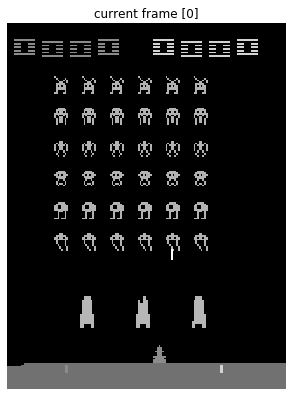

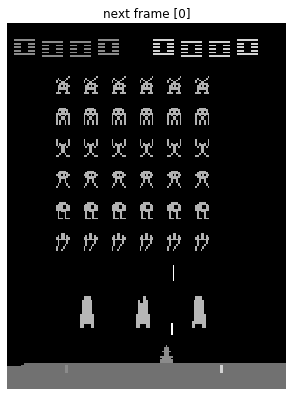

In [17]:
#get some information from  the batch to make sure it looks good.

import matplotlib.pyplot as plt

#frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch = get_train_batch(atari_env_train, batch_size)
frame_batch, next_frame_batch, actions_batch, next_actions_batch, reward_batch, frame_number_batch, lambda_reward_batch = get_train_batch(atari_env_train, batch_size, lambda_frames, gamma)

print("action: {}".format(actions_batch[0]))
print("reward: {}".format(reward_batch[0]))
print("frame:  {}".format(frame_number_batch[0]))

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("current frame [0]")
plt.imshow(frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("current frame [2]")
# plt.imshow(frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("next frame [0]")
plt.imshow(next_frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("next frame [2]")
# plt.imshow(next_frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()

In [19]:
for i in range(500):
    reward = atari_env_train.frame_buffer[-i].getReward()
    print(reward)

0.0
-5.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0